# COURSERA CAPSTONE FINAL PROJECT

## Installing required resources

In [2]:
!pip install geocoder
!pip install folium

     |████████████████████████████████| 98 kB 6.8 MB/s  eta 0:00:01
     |████████████████████████████████| 93 kB 2.7 MB/s eta 0:00:011


### Importing required libraries

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
print("All Required Libraries Imported and packages installed")

All Required Libraries Imported and packages installed


## Extracting Data

In [4]:
List_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(List_url).text

### Using BeautifulSoup for scrapping postal code data

In [5]:
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')

### making dataframe

In [6]:
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)

In [7]:
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [8]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Sorting based on Borough

In [9]:
df = df.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn


In [10]:
df.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M2P,Not assigned,Not assigned
freq,1,77,77


### Cleaning the data

In [11]:
indexNames = df[ df['Borough'] =='Not assigned'].index
df.drop(indexNames , inplace=True)

In [12]:
df.head()

,Postalcode,Borough,Neighborhood
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae


In [13]:
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']

In [14]:
df.head(10)

,Postalcode,Borough,Neighborhood
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae
6,M1J,Scarborough,Scarborough Village
7,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
8,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
9,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
10,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [15]:
df.shape

(103, 3)

### Using Geocoder package and using CSV file with geographical coordinates from the given website

In [16]:
!wget -q -O 'Toronto_long_lat_data.csv'  http://cocl.us/Geospatial_data
df_lon_lat = pd.read_csv('Toronto_long_lat_data.csv')
df_lon_lat.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### defining columns

In [17]:
df_lon_lat.columns=['Postalcode','Latitude','Longitude']

In [18]:
df_lon_lat.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### merging using pandas

In [19]:
Toronto_df = pd.merge(df,
                 df_lon_lat[['Postalcode','Latitude', 'Longitude']],
                 on='Postalcode')
Toronto_df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [20]:
address = 'North York, Toronto'

geolocator = Nominatim(user_agent="North York")
location = geolocator.geocode(address)
latitude_b = location.latitude
longitude_b = location.longitude
print('The geograpical coordinate of North York, ON, Canada are {}, {}.'.format(latitude_b, longitude_b))

The geograpical coordinate of North York, ON, Canada are 43.7543263, -79.44911696639593.


### Creating a Map

In [21]:
map_toronto = folium.Map(location=[latitude_b, longitude_b], zoom_start=10)

# add markers to map
for lat, lng, borough, Neighborhood in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Borough'], Toronto_df['Neighborhood']):
    label = '{}, {}'.format(Neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [22]:
CLIENT_ID = 'D2GNOEWUY2EO32FEYR0MESZMA4MTZ4OYYU5JPGEMFC5T24TW' # Foursquare ID
CLIENT_SECRET = 'QYY3RAB4GLNEFEHURTBJZDFFPH5JZKAR30AJNE5XPDPE4VQJ' # Foursquare Secret
VERSION = '20201110'
radius=500
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D2GNOEWUY2EO32FEYR0MESZMA4MTZ4OYYU5JPGEMFC5T24TW
CLIENT_SECRET:QYY3RAB4GLNEFEHURTBJZDFFPH5JZKAR30AJNE5XPDPE4VQJ


In [23]:
from pandas.io.json import json_normalize 

In [24]:
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_b, 
   longitude_b, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [25]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [26]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Getting nearby Locations

In [27]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
2,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
3,Crave Restaurant,"[{'id': '4bf58dd8d48988d14c941735', 'name': 'W...",43.753133,-79.450378
4,lori@itsyourtreasure.com,"[{'id': '4bf58dd8d48988d108951735', 'name': 'W...",43.750265,-79.447868


### Getting categories for the locations of interest

In [28]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head(10)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Tim Hortons,Coffee Shop,43.754767,-79.443250
2,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
3,Crave Restaurant,Wings Joint,43.753133,-79.450378
4,lori@itsyourtreasure.com,Women's Store,43.750265,-79.447868


### Category frequency

In [29]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Mediterranean Restaurant     1
Wings Joint                  1
Women's Store                1
Middle Eastern Restaurant    1
Coffee Shop                  1
Name: categories, dtype: int64

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
toronto_venues = getNearbyVenues(names=Toronto_df['Neighborhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [33]:
toronto_venues.head(10)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
5,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant
6,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
7,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location
8,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center
9,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection


In [34]:
toronto_venues.shape

(2139, 7)

#### Venues based on neighbourhoods

In [35]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4
Woodbine Heights,8,8,8,8,8,8


In [36]:
print('There are {} Uniques Categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.groupby('Neighbourhood').count().head()

There are 274 Uniques Categories.


,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22


### Analyzing Neighbourhoods

In [37]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Malvern, Rouge"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Rouge Hill, Port Union, Highland Creek"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Rouge Hill, Port Union, Highland Creek"
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Guildwood, Morningside, West Hill"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Guildwood, Morningside, West Hill"


In [38]:
toronto_onehot.shape

(2139, 275)

Grouping rows by Neighborhood and visualizing mean and freq

In [39]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Neighborhood with 5 most common venues
Note that results are in 0, 1, 2, 3 and 4. Not 1, 2, 3, 4 and 5.

In [40]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Agincourt----
                       venue  freq
0             Clothing Store   0.2
1             Breakfast Spot   0.2
2                     Lounge   0.2
3               Skating Rink   0.2
4  Latin American Restaurant   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.29
1             Gym  0.14
2  Sandwich Place  0.14
3     Coffee Shop  0.14
4             Pub  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0         Bank  0.10
1  Coffee Shop  0.10
2     Pharmacy  0.05
3        Diner  0.05
4  Gas Station  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1   Chinese Restaurant  0.25
2                 Bank  0.25
3                 Café  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.09
1         Coffee Shop  0.09
2  Italian Restaurant  0.09
3            Pharmacy  0.05
4                 Pub  0.05

                  venue  freq
0                Bakery  0.06
1                   Gym  0.06
2           Social Club  0.06
3  Fast Food Restaurant  0.06
4        Sandwich Place  0.06


----Moore Park, Summerhill East----
                 venue  freq
0           Playground   0.5
1                Trail   0.5
2        Movie Theater   0.0
3  Moroccan Restaurant   0.0
4  Monument / Landmark   0.0


----New Toronto, Mimico South, Humber Bay Shores----
                 venue  freq
0                 Café  0.14
1          Coffee Shop  0.14
2          Pizza Place  0.07
3  American Restaurant  0.07
4           Restaurant  0.07


----North Park, Maple Leaf Park, Upwood Park----
                        venue  freq
0  Construction & Landscaping  0.33
1                      Bakery  0.33
2                        Park  0.33
3           Accessories Store  0.00
4   Middle Eastern Restaurant  0.00


----North Toronto West,  Lawrence Park----
                  venue  freq
0           Coffee Shop  0.11
1      

#### Dataframe of common venues

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Pharmacy,Gym,Grocery Store,Deli / Bodega,Electronics Store,Eastern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Frozen Yogurt Shop,Chinese Restaurant,Shopping Mall,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Supermarket
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Grocery Store,Thai Restaurant,Locksmith,Liquor Store,Comfort Food Restaurant,Butcher,Juice Bar


## K-means Clustering

In [43]:
kclusters = 3
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

looking entire dataset of locations

In [44]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(Toronto_df)

    Postalcode           Borough  \
0          M1B       Scarborough   
1          M1C       Scarborough   
2          M1E       Scarborough   
3          M1G       Scarborough   
4          M1H       Scarborough   
5          M1J       Scarborough   
6          M1K       Scarborough   
7          M1L       Scarborough   
8          M1M       Scarborough   
9          M1N       Scarborough   
10         M1P       Scarborough   
11         M1R       Scarborough   
12         M1S       Scarborough   
13         M1T       Scarborough   
14         M1V       Scarborough   
15         M1W       Scarborough   
16         M1X       Scarborough   
17         M2H        North York   
18         M2J        North York   
19         M2K        North York   
20         M2L        North York   
21         M2M        North York   
22         M2N        North York   
23         M2P        North York   
24         M2R        North York   
25         M3A        North York   
26         M3B        North 

In [45]:
neighbourhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)
ny_merged =Toronto_df.iloc[17:35] # for North York
ny_merged = ny_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighborhood')
ny_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.803762,-79.363452,1.0,Golf Course,Athletics & Sports,Dog Run,Pool,Mediterranean Restaurant,Dumpling Restaurant,Distribution Center,Doner Restaurant,Donut Shop,Drugstore
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,1.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Juice Bar,Women's Store,Restaurant,Cosmetics Shop,Shoe Store,Bank
19,M2K,North York,Bayview Village,43.786947,-79.385975,1.0,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
20,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,1.0,Martial Arts School,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
21,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
ny_merged

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.803762,-79.363452,1.0,Golf Course,Athletics & Sports,Dog Run,Pool,Mediterranean Restaurant,Dumpling Restaurant,Distribution Center,Doner Restaurant,Donut Shop,Drugstore
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,1.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Juice Bar,Women's Store,Restaurant,Cosmetics Shop,Shoe Store,Bank
19,M2K,North York,Bayview Village,43.786947,-79.385975,1.0,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
20,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,1.0,Martial Arts School,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
21,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,M2N,North York,"Willowdale, Willowdale East",43.770120,-79.408493,1.0,Ramen Restaurant,Sushi Restaurant,Sandwich Place,Japanese Restaurant,Pizza Place,Coffee Shop,Café,Movie Theater,Juice Bar,Grocery Store
23,M2P,North York,York Mills West,43.752758,-79.400049,0.0,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
24,M2R,North York,"Willowdale, Willowdale West",43.782736,-79.442259,1.0,Pizza Place,Grocery Store,Butcher,Coffee Shop,Pharmacy,Construction & Landscaping,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant
25,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
26,M3B,North York,Don Mills,43.745906,-79.352188,1.0,Gym,Japanese Restaurant,Beer Store,Coffee Shop,Caribbean Restaurant,Clothing Store,Italian Restaurant,Café,Discount Store,Chinese Restaurant


In [47]:
ny_merged=ny_merged.dropna()

In [48]:
ny_merged

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.803762,-79.363452,1.0,Golf Course,Athletics & Sports,Dog Run,Pool,Mediterranean Restaurant,Dumpling Restaurant,Distribution Center,Doner Restaurant,Donut Shop,Drugstore
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,1.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Juice Bar,Women's Store,Restaurant,Cosmetics Shop,Shoe Store,Bank
19,M2K,North York,Bayview Village,43.786947,-79.385975,1.0,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
20,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,1.0,Martial Arts School,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
22,M2N,North York,"Willowdale, Willowdale East",43.770120,-79.408493,1.0,Ramen Restaurant,Sushi Restaurant,Sandwich Place,Japanese Restaurant,Pizza Place,Coffee Shop,Café,Movie Theater,Juice Bar,Grocery Store
23,M2P,North York,York Mills West,43.752758,-79.400049,0.0,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
24,M2R,North York,"Willowdale, Willowdale West",43.782736,-79.442259,1.0,Pizza Place,Grocery Store,Butcher,Coffee Shop,Pharmacy,Construction & Landscaping,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant
25,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
26,M3B,North York,Don Mills,43.745906,-79.352188,1.0,Gym,Japanese Restaurant,Beer Store,Coffee Shop,Caribbean Restaurant,Clothing Store,Italian Restaurant,Café,Discount Store,Chinese Restaurant
27,M3C,North York,Don Mills,43.725900,-79.340923,1.0,Gym,Japanese Restaurant,Beer Store,Coffee Shop,Caribbean Restaurant,Clothing Store,Italian Restaurant,Café,Discount Store,Chinese Restaurant


In [49]:
ny_merged['Cluster_Labels'] = ny_merged.Cluster_Labels.astype(int)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [50]:
kclusters=3
# create map
map_clusters = folium.Map(location=[latitude_b, longitude_b], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(ny_merged['Latitude'], 
                                   ny_merged['Longitude'], 
                                   ny_merged['Neighborhood'], 
                                   ny_merged['Cluster_Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#80ffb4', '#ff0000']


## Exploring clusters

### Cluster 1

In [51]:
cl1 = ny_merged.loc[ny_merged['Cluster_Labels'] == 0, :]

## Cluster 2

In [52]:
cl2 = ny_merged.loc[ny_merged['Cluster_Labels'] == 1, :]

In [53]:
cl1

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,M2P,North York,York Mills West,43.752758,-79.400049,0,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
25,M3A,North York,Parkwoods,43.753259,-79.329656,0,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store


In [54]:
cl2

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.803762,-79.363452,1,Golf Course,Athletics & Sports,Dog Run,Pool,Mediterranean Restaurant,Dumpling Restaurant,Distribution Center,Doner Restaurant,Donut Shop,Drugstore
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,1,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Juice Bar,Women's Store,Restaurant,Cosmetics Shop,Shoe Store,Bank
19,M2K,North York,Bayview Village,43.786947,-79.385975,1,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
20,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,1,Martial Arts School,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
22,M2N,North York,"Willowdale, Willowdale East",43.770120,-79.408493,1,Ramen Restaurant,Sushi Restaurant,Sandwich Place,Japanese Restaurant,Pizza Place,Coffee Shop,Café,Movie Theater,Juice Bar,Grocery Store
24,M2R,North York,"Willowdale, Willowdale West",43.782736,-79.442259,1,Pizza Place,Grocery Store,Butcher,Coffee Shop,Pharmacy,Construction & Landscaping,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant
26,M3B,North York,Don Mills,43.745906,-79.352188,1,Gym,Japanese Restaurant,Beer Store,Coffee Shop,Caribbean Restaurant,Clothing Store,Italian Restaurant,Café,Discount Store,Chinese Restaurant
27,M3C,North York,Don Mills,43.725900,-79.340923,1,Gym,Japanese Restaurant,Beer Store,Coffee Shop,Caribbean Restaurant,Clothing Store,Italian Restaurant,Café,Discount Store,Chinese Restaurant
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,1,Bank,Coffee Shop,Frozen Yogurt Shop,Chinese Restaurant,Shopping Mall,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Supermarket
29,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,1,Metro Station,Coffee Shop,Caribbean Restaurant,Bar,Miscellaneous Shop,Furniture / Home Store,Massage Studio,Electronics Store,Eastern European Restaurant,Escape Room


## Adding Housing price list to the clustered data
### The source for housing price data is: https://housepricehub.com/areas

In [56]:
cl1_housing_price = pd.DataFrame({"Neighborhood":cl1["Neighborhood"], "Mean_Housing_Price":[4072540.0, 1881252.0]})

In [57]:
cl1_housing_price

,Neighborhood,Mean_Housing_Price
23,York Mills West,4072540.0
25,Parkwoods,1881252.0


In [58]:
cl2_housing_price = pd.DataFrame({"Neighborhood":cl2["Neighborhood"], "Mean_Housing_Price":[1291280.0, 1598553.0, 2381172.0, 6412069.0, 2516874.0, 1787427.0, 5124627.0, 4580833.0, 1819456.0, 1005796.0, 1275383.0, 780966.0, 1172519.0, 885369.0, 1272660.0]})

In [59]:
cl2_housing_price

,Neighborhood,Mean_Housing_Price
17,Hillcrest Village,1291280.0
18,"Fairview, Henry Farm, Oriole",1598553.0
19,Bayview Village,2381172.0
20,"York Mills, Silver Hills",6412069.0
22,"Willowdale, Willowdale East",2516874.0
24,"Willowdale, Willowdale West",1787427.0
26,Don Mills,5124627.0
27,Don Mills,4580833.0
28,"Bathurst Manor, Wilson Heights, Downsview North",1819456.0
29,"Northwood Park, York University",1005796.0


In [60]:
cl1_housing_price.set_index('Neighborhood',inplace=True,drop=True)

In [61]:
cl1_housing_price

,Mean_Housing_Price
Neighborhood,
York Mills West,4072540.0
Parkwoods,1881252.0


In [62]:
cl2_housing_price.set_index('Neighborhood',inplace=True,drop=True)

In [63]:
cl2_housing_price

,Mean_Housing_Price
Neighborhood,
Hillcrest Village,1291280.0
"Fairview, Henry Farm, Oriole",1598553.0
Bayview Village,2381172.0
"York Mills, Silver Hills",6412069.0
"Willowdale, Willowdale East",2516874.0
"Willowdale, Willowdale West",1787427.0
Don Mills,5124627.0
Don Mills,4580833.0
"Bathurst Manor, Wilson Heights, Downsview North",1819456.0


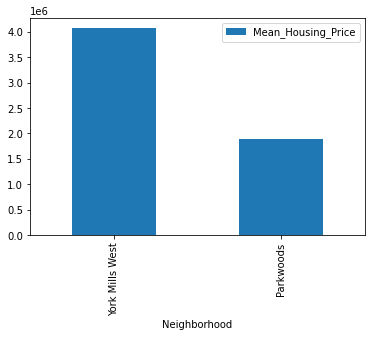

In [68]:
cl1_housing_price.plot(kind='bar')

NameError: name 'plt' is not defined

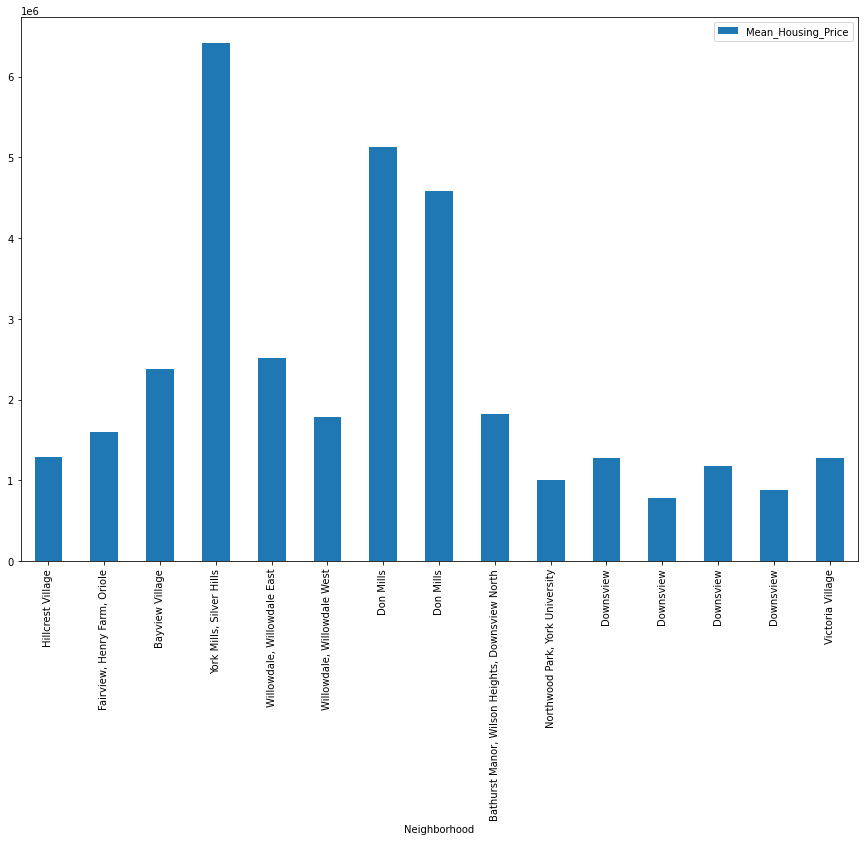

In [78]:
cl2_housing_price.plot(kind='bar', figsize=(15,10))

In [85]:
cl1_mean = cl1_housing_price["Mean_Housing_Price"].mean()
cl1_mean

2976896.0

In [86]:
cl2_mean = cl2_housing_price["Mean_Housing_Price"].mean()
cl2_mean

2260332.2666666666

In [83]:
mean_df=[cl1_mean, cl2_mean]

In [84]:
mean_df

[2976896.0, 2260332.2666666666]

In [82]:
import numpy as np
import matplotlib.pyplot as plt


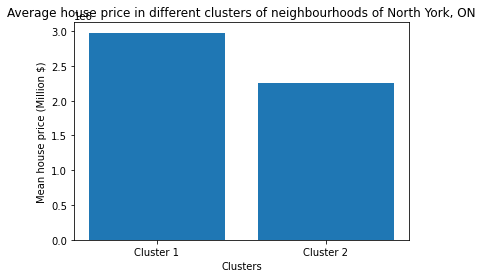

In [89]:
lbls = ['Cluster 1', 'Cluster 2']
y_pos = np.arange(len(lbls))
plt.bar(y_pos, mean_df)
plt.title('Average house price in different clusters of neighbourhoods of North York, ON')
plt.xlabel('Clusters')
plt.ylabel('Mean house price (Million $)')
plt.xticks(y_pos, lbls)
plt.show()